In [12]:
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
import time

import sys, os
sys.path.append(os.path.abspath("/tudelft.net/staff-umbrella/refsetopt/SELECTION_PROJECT/github_final/src"))
import solution.solution_optimized as sol

import importlib
importlib.reload(sol)

<module 'solution.solution_optimized' from '/tudelft.net/staff-umbrella/refsetopt/SELECTION_PROJECT/github_final/src/solution/solution_optimized.py'>

In [13]:
import numpy as np
import random
from scipy.spatial.distance import cdist
import pandas as pd

def generate_data(num_clusters: int, cluster_size: int = 5, random_size: bool = False, lb: int = 1, ub: int = 10, max_dist: float = None, seed: int = 0):
    """
    Generate data on a unit square with a diameter of 1 (i.e. max distance between points is 1). (for now this is not implemented)
    Parameters:
        - num_clusters (int):
            Number of clusters to generate
        - cluster_size (int):
            Number of points in a cluster
        - random_size (bool):
            Set to True if generating randomly sized clusters with size in [1,cluster_size] (inclusive)
        - lb (int):
            Minimal number of points in a cluster
        - ub (int):
            Maximal number of points in a cluster
        - max_dist (float):
            Maximal distance between any pair of points
        - seed (int):
            Seed to use for randomization of points
    Returns:
        - distance_matrix (np.array[np.float32]):
            Distance matrix of all points simulated
        - clusters (list[int]):
            Cluster assignment (every point is assigned a cluster)
    """
    if seed > 0:
        np.random.seed(seed)
        random.seed(seed)
    
    data = []
    clusters = []
    cur_cluster_id = 0
    for _ in range(num_clusters):
        if random_size:
            cluster_size = np.random.randint(lb,ub)
        # Simulate cluster mean
        cur_mean = np.random.rand(2)* min(10, num_clusters) #multiply by #clusters/2 in order to create potentially distinct clusters
        # Simulate cluster shape (covariance matrix)
        cur_std = np.random.rand()*0.3 + 0.2
        cur_cov = np.random.rand()*cur_std - 1e-3
        cur_cov = random.choice([[[cur_std, cur_cov], [cur_cov, cur_std]], [[cur_std, -cur_cov], [-cur_cov, cur_std]]])
        #cur_cov = random.choice([[[2,0],[0,2]], [[1,0],[0,1]], [[2,1],[1,2]], [[1,0.5], [0.5,1]]])
        # Generate points for current cluster and add to data
        cur_points = np.random.multivariate_normal(cur_mean, cur_cov, cluster_size)
        for point in cur_points:
            data.append(point)
            clusters.append(cur_cluster_id)
        cur_cluster_id += 1

    data = np.array(data, dtype=np.float32)
    distances = cdist(data, data, "euclidean")
    # Scale data
    if max_dist:
        scale = max_dist / np.max(distances)
        distances = scale * distances
        data = scale * data
    # Convert to DataFrame
    df = pd.DataFrame(data, columns=["x", "y"])
    df["clusters"] = [str(c) for c in clusters]

    return df, np.array(clusters, dtype=np.int64), np.array(distances, dtype=np.float32)

(1459,)
(1459, 1459)


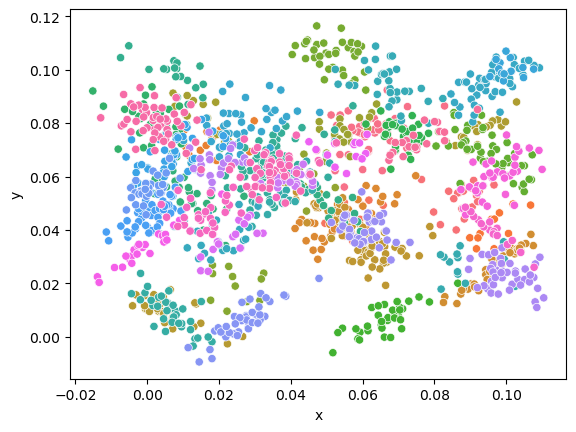

In [14]:
df, clusters, distances = generate_data(num_clusters=50, random_size=True, lb=10, ub=50, max_dist=0.15)
sb.scatterplot(data=df, x="x", y="y", hue="clusters", legend=False)

print(clusters.shape)
print(distances.shape)

In [21]:
solution_centroid = sol.Solution.generate_centroid_solution(distances, clusters, selection_cost=0.1)
solution_random_10 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.1, max_fraction=0.10, seed=1234)
solution_random_25 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.1, max_fraction=0.25, seed=12345)
solution_random_50 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.1, max_fraction=0.50, seed=123456)
solution_random_75 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.1, max_fraction=0.75, seed=1234567)
solution_random_100 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.1, max_fraction=1.0, seed=12345678)

print("Instance consists of 1459 points over 50 clusters")
print(f"Centroid objective (cost for selecting = 0.1): {solution_centroid.objective:.5f} with {np.sum(solution_centroid.selection)} selected points")
print(f"Random (10%) objective (cost for selecting = 0.1): {solution_random_10.objective:.5f} with {np.sum(solution_random_10.selection)} selected points")
print(f"Random (25%) objective (cost for selecting = 0.1): {solution_random_25.objective:.5f} with {np.sum(solution_random_25.selection)} selected points")
print(f"Random (50%) objective (cost for selecting = 0.1): {solution_random_50.objective:.5f} with {np.sum(solution_random_50.selection)} selected points")
print(f"Random (75%) objective (cost for selecting = 0.1): {solution_random_75.objective:.5f} with {np.sum(solution_random_75.selection)} selected points")
print(f"Random (100%) objective (cost for selecting = 0.1): {solution_random_100.objective:.5f} with {np.sum(solution_random_100.selection)} selected points")

Instance consists of 1459 points over 50 clusters
Centroid objective (cost for selecting = 0.1): 1175.80250 with 50 selected points
Random (10%) objective (cost for selecting = 0.1): 1191.89549 with 145 selected points
Random (25%) objective (cost for selecting = 0.1): 1217.87912 with 364 selected points
Random (50%) objective (cost for selecting = 0.1): 1257.40937 with 729 selected points
Random (75%) objective (cost for selecting = 0.1): 1294.69700 with 1094 selected points
Random (100%) objective (cost for selecting = 0.1): 1331.61528 with 1459 selected points


In [34]:
# Solve centroid problem using standard priority
solution_centroid = sol.Solution.generate_centroid_solution(distances, clusters, selection_cost=0.001)
start_time = time.time()
O_centroid, S_centroid = solution_centroid.local_search(max_iterations=500, best_swap=False)
end_time = time.time()
print(f"Local optimum found after {len(O_centroid)-1} iterations: {solution_centroid.objective:.5f} with {np.sum(solution_centroid.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

Iteration 200: Objective = 1169.5652148582983
Iteration 400: Objective = 1167.276295435467
Local optimum found after 500 iterations: 1166.30345 with 359 selected points
Time elapsed: 274.47 seconds


In [35]:
# Solve centroid problem focusing on removing first
solution_centroid = sol.Solution.generate_centroid_solution(distances, clusters, selection_cost=0.001)
start_time = time.time()
O_centroid, S_centroid = solution_centroid.local_search_removefirst(max_iterations=500, best_swap=False)
end_time = time.time()
print(f"Local optimum found after {len(O_centroid)-1} iterations: {solution_centroid.objective:.5f} with {np.sum(solution_centroid.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

Iteration 200: Objective = 1165.7805256691183
Local optimum found after 318 iterations: 1161.53102 with 81 selected points
Time elapsed: 34.13 seconds


In [37]:
# Solve centroid problem using random priority
solution_centroid = sol.Solution.generate_centroid_solution(distances, clusters, selection_cost=0.001)
start_time = time.time()
O_centroid, S_centroid = solution_centroid.local_search_random(max_iterations=500)
end_time = time.time()
print(f"Local optimum found after {len(O_centroid)-1} iterations: {solution_centroid.objective:.5f} with {np.sum(solution_centroid.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

Iteration 200: Objective = 1164.9265176931187
Local optimum found after 328 iterations: 1161.54635 with 83 selected points
Time elapsed: 105.26 seconds


In [38]:
# Solve random 10% problem using standard priority
solution_random_10 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.001, max_fraction=0.10, seed=1234)
start_time = time.time()
O_random_10, S_random_10 = solution_random_10.local_search(max_iterations=500, best_swap=False)
end_time = time.time()
print(f"Local optimum found after {len(O_random_10)-1} iterations: {solution_random_10.objective:.5f} with {np.sum(solution_random_10.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

Iteration 200: Objective = 1176.6277431710128
Iteration 400: Objective = 1175.4853325606014
Local optimum found after 500 iterations: 1174.89565 with 645 selected points
Time elapsed: 36.52 seconds


In [39]:
# Solve random 10% problem focussing on removing first
solution_random_10 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.001, max_fraction=0.10, seed=1234)
start_time = time.time()
O_random_10, S_random_10 = solution_random_10.local_search_removefirst(max_iterations=500, best_swap=False)
end_time = time.time()
print(f"Local optimum found after {len(O_random_10)-1} iterations: {solution_random_10.objective:.5f} with {np.sum(solution_random_10.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

Iteration 200: Objective = 1166.8411442956271
Local optimum found after 375 iterations: 1161.54087 with 76 selected points
Time elapsed: 31.25 seconds


In [40]:
# Solve random 10% problem using random priority
solution_random_10 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.001, max_fraction=0.10, seed=1234)
start_time = time.time()
O_random_10, S_random_10 = solution_random_10.local_search_random(max_iterations=500)
end_time = time.time()
print(f"Local optimum found after {len(O_random_10)-1} iterations: {solution_random_10.objective:.5f} with {np.sum(solution_random_10.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

Iteration 200: Objective = 1167.3421713298765
Local optimum found after 374 iterations: 1161.53944 with 74 selected points
Time elapsed: 83.87 seconds


In [41]:
# Solve random 25% problem using standard priority
solution_random_25 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.001, max_fraction=0.25, seed=1234)
start_time = time.time()
O_random_25, S_random_25 = solution_random_25.local_search(max_iterations=500, best_swap=False)
end_time = time.time()
print(f"Local optimum found after {len(O_random_25)-1} iterations: {solution_random_25.objective:.5f} with {np.sum(solution_random_25.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

Iteration 200: Objective = 1180.5305057317714
Iteration 400: Objective = 1179.9018182540262
Local optimum found after 500 iterations: 1179.66047 with 864 selected points
Time elapsed: 28.75 seconds


In [42]:
# Solve random 25% problem focussing on removing first
solution_random_25 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.001, max_fraction=0.25, seed=1234)
start_time = time.time()
O_random_25, S_random_25 = solution_random_25.local_search_removefirst(max_iterations=500, best_swap=False)
end_time = time.time()
print(f"Local optimum found after {len(O_random_25)-1} iterations: {solution_random_25.objective:.5f} with {np.sum(solution_random_25.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

Iteration 200: Objective = 1170.9373239437923
Iteration 400: Objective = 1164.7315211186046
Local optimum found after 475 iterations: 1161.56770 with 81 selected points
Time elapsed: 28.57 seconds


In [43]:
# Solve random 25% problem focussing on removing first
solution_random_25 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.001, max_fraction=0.25, seed=1234)
start_time = time.time()
O_random_25, S_random_25 = solution_random_25.local_search_random(max_iterations=500)
end_time = time.time()
print(f"Local optimum found after {len(O_random_25)-1} iterations: {solution_random_25.objective:.5f} with {np.sum(solution_random_25.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

Iteration 200: Objective = 1171.9256076968604
Iteration 400: Objective = 1164.9073089111737
Local optimum found after 500 iterations: 1162.55431 with 79 selected points
Time elapsed: 45.95 seconds


In [45]:
# Solve random 100% problem using standard priority
solution_random_100 = sol.Solution.generate_random_solution(distances, clusters, selection_cost=0.001, max_fraction=1.0, seed=1234)
start_time = time.time()
O_random_100, S_random_100 = solution_random_100.local_search_random(max_iterations=5000)
end_time = time.time()
print(f"Local optimum found after {len(O_random_100)-1} iterations: {solution_random_100.objective:.5f} with {np.sum(solution_random_100.selection)} selected points")
print(f"Time elapsed: {end_time - start_time:.2f} seconds")

Iteration 200: Objective = 1184.562200580998
Iteration 400: Objective = 1180.4832706174054
Iteration 600: Objective = 1176.9062635568532
Iteration 800: Objective = 1172.65665574625
Iteration 1000: Objective = 1170.2983888151912
Iteration 1200: Objective = 1167.6478045076865
Iteration 1400: Objective = 1163.6899789082531
Local optimum found after 1490 iterations: 1161.56146 with 86 selected points
Time elapsed: 138.93 seconds


In [30]:
import itertools
import numpy as np

# Functions for calculating the groundtruth
def groundtruth_objective_value(selection, clusters, distances, selection_cost):
    inter_normalization = 1 # normalization factor for inter cluster distances
    intra_normalization = 1# normalization factor for intra cluster distances
    # Cost for selecting items
    objective_value = np.sum(selection) * selection_cost
    print("Selection cost:", objective_value)
    # Intra cluster costs
    cur = 0
    for idx in np.where(~selection)[0]:
        cur_min = np.inf
        for other_idx in np.where((clusters == clusters[idx]) & selection)[0]:
            cur_min = min(cur_min, distances[idx, other_idx])
        objective_value += cur_min / intra_normalization
        cur += cur_min / intra_normalization
    print("Intra cluster cost:", cur)
    # Inter cluster costs
    cur = 0
    unique_clusters = np.unique(clusters)
    for cluster_pair in itertools.combinations(unique_clusters, 2):
        cluster_1 = np.where((clusters == cluster_pair[0]) & selection)[0]
        cluster_2 = np.where((clusters == cluster_pair[1]) & selection)[0]
        cur_max = -np.inf
        for point_pair in itertools.product(cluster_1, cluster_2):
            cur_max = max(cur_max, 1 - distances[point_pair[0], point_pair[1]])
        objective_value += cur_max / inter_normalization
        cur += cur_max / inter_normalization
    print("Inter cluster cost:", cur)
    return objective_value

In [44]:
print("Centroid")
print("Total cost:", groundtruth_objective_value(solution_centroid.selection, clusters, distances, selection_cost=0.1))
print("Random 10%")
print("Total cost:", groundtruth_objective_value(solution_random_10.selection, clusters, distances, selection_cost=0.1))
print("Random 25%")
print("Total cost:", groundtruth_objective_value(solution_random_25.selection, clusters, distances, selection_cost=0.1))

Centroid
Selection cost: 8.3
Intra cluster cost: 15.276602
Inter cluster cost: 1146.186
Total cost: 1169.7633495405723
Random 10%
Selection cost: 7.4
Intra cluster cost: 15.414068
Inter cluster cost: 1146.0507
Total cost: 1168.865437115272
Random 25%
Selection cost: 7.9
Intra cluster cost: 14.646471
Inter cluster cost: 1147.8287
Total cost: 1170.375306487686
